# Events and statistics from ROIs

This example illustrates the usage of regions of interest (ROIs) to capture statistics and interesting events from footage, under the assumption that the camera has a fixed position and orientation.

Contents:

1. Loading and displaying ROIs.
2. Counting objects inside ROIs.
3. Triggering interesting events.

In [1]:
%load_ext autoreload
%autoreload 2

In [65]:
from videoanalytics.pipeline import Pipeline
from videoanalytics.pipeline.sources import VideoReader
from videoanalytics.pipeline.sinks import VideoWriter, VariableCSVWriter

## Loading and displaying ROIs

### Configuration

#### Input and output video

We will be using the same video as in the previous examples.
Note: the video used in this example was downloaded from [youtube](https://www.youtube.com/watch?v=WgCe0tMO4lA).

In [118]:
DATA_PATH = "../data/"

# Input
INPUT_VIDEO = DATA_PATH+"/input/test_video.mp4"
START_FRAME = 0
MAX_FRAMES = 1000

In [4]:
%%HTML
<div style="text-align: center">
    <video width="600" height="400" controls>
      <source src="../data/input/test_video.mp4" type="video/mp4">
    </video>
</div>

In [6]:
# Output
OUTPUT_VIDEO = DATA_PATH+ "/output/test_output.avi"

#### Definition of ROIs

In [7]:
ROI_DEFINITION_FILE= DATA_PATH+"/roi/mirtar.json"
!cat {ROI_DEFINITION_FILE}

{
	"regions": [
		{
			"name": "upper_left",
			"polygon": [[385, 315], [676, 334], [754, 625], [668, 810], [165, 757]],
			"color": [155,155,0]
		},

		{
			"name": "lower_left",
			"polygon": [[11, 532], [777, 606], [666, 1073], [5, 1074]],
			"color": [155,155,0]
		},

		{
			"name": "upper_right",
			"polygon": [[1057, 336], [908, 682], [954, 773], [1522, 754], [1565, 595], [1210, 305]],
			"color": [155,0,155]
		},

		{
			"name": "lower_right",
			"polygon": [[973, 1072], [949, 625], [1749, 538], [1904, 1068]],
			"color": [155,0,155]
		},


		{
			"name": "winch",
			"polygon": [[1088, 369], [592, 382], [570, 580], [1131, 584]],
			"color": [0,255,0]
		}
	]		
}

### Pipeline instantiation and execution

In [8]:
from videoanalytics.pipeline.sinks.roi import ROIView

In [9]:
# 1. Create the global context
context = {}

# 2. Create the pipeline
pipeline = Pipeline()

# 3. Add components

# 3.1 Source
pipeline.add_component( VideoReader( "input",context,
                 video_path=INPUT_VIDEO,
                 start_frame=START_FRAME,
                 max_frames=MAX_FRAMES))

In [10]:
# 3.2 ROI viewer
pipeline.add_component( ROIView("roi_view",context,filename=ROI_DEFINITION_FILE,alpha=0.6 ) )

In [11]:
# 3.3 Sink
pipeline.add_component(VideoWriter("writer",context,filename=OUTPUT_VIDEO))

In [12]:
# 4. Define connections
pipeline.set_connections([
    ("input", "roi_view"),
    ("roi_view", "writer")
])

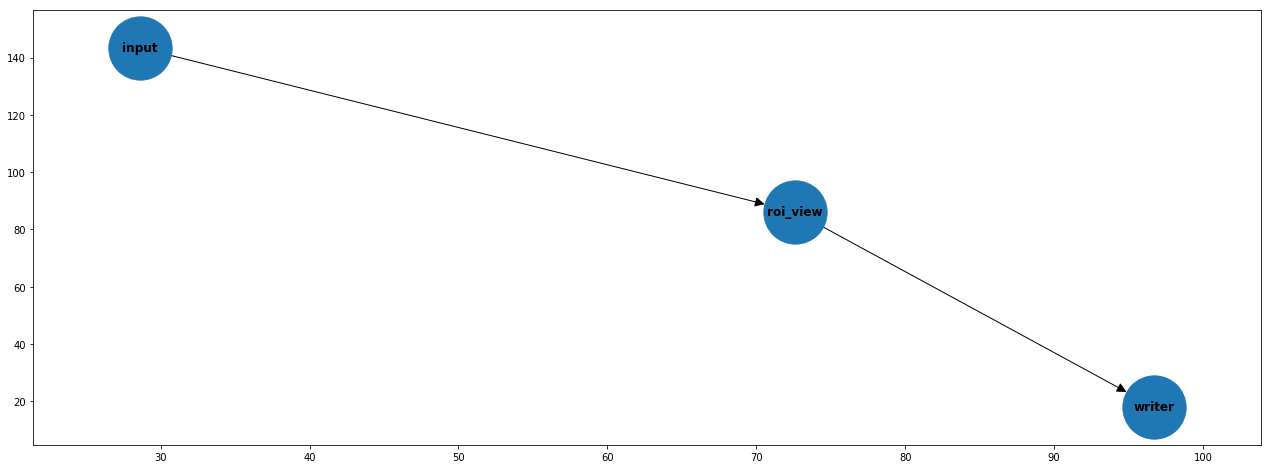

In [13]:
import matplotlib.pyplot as plt

fig,axes = plt.subplots(1,1,figsize=(22,8))
pipeline.plot(ax=axes)

In [14]:
# 5. Execute
pipeline.execute()
print("Total execution time [s]:", pipeline.get_total_execution_time())

  0%|          | 0/100.0 [00:00<?, ?it/s]

Total execution time [s]: 30.61876826400112


In [ ]:
import pandas as pd

# 6. Report (optional)
metrics_df = pd.DataFrame.from_dict(pipeline.get_metrics(), orient='index',columns=["time [s]"])
metrics_df

### Exploration of results

Display the output video with annotated ROIs.

Note: currently XVID format is not supported by jupyter.

In [54]:
%%HTML
<div style="text-align: center">
    <video width="600" height="400" controls>
      <source src="../data/output/test_output.avi" type="video/mp4">
    </video>
</div>

## A pipeline for counting objects inside ROIs

A more real and useful application is to obtain statistics (object count, activity, etc.) to associate the activity in each ROI to interesting patterns in the footage. The following example counts the total instances for each ROI. Note that certain areas indicate that a particular acitvity is being performed, such as rising the networks or classifying the catch from the deck.

In [16]:
from videoanalytics.pipeline.sinks.roi import ROIPresenceCounter
from videoanalytics.pipeline.sinks.visualization import TextOverlay

In [18]:
# Specific components for object detection
from videoanalytics.pipeline.sinks.object_detection import DetectionsAnnotator, DetectionsCSVWriter
from videoanalytics.pipeline.sinks.object_detection.yolo4 import YOLOv4DetectorTF

In [30]:
# Detector

# Object Detector model weights (Tensorflow)
DETECTOR_WEIGHTS_FILENAME = DATA_PATH+ "object_detection/checkpoints/yolov4-416-tf"
#DETECTOR_WEIGHTS_FILENAME = DATA_PATH+ "object_detection/checkpoints/yolov4-tiny-416"


# Classes names for Detections Annotator
DETECTOR_CLASSES_FILENAME = DATA_PATH+"object_detection/classes_definitions/coco.txt"

# CSV with Detections filename
DETECTIONS_FILENAME = DATA_PATH+"/output/detections.csv"

# CSV with variables
VARIABLES_FILENAME = DATA_PATH+"/output/variables.csv"

### Pipeline instantiation and execution

In [56]:
# 1. Create the global context
context = {}

# 2. Create the pipeline
pipeline = Pipeline()

# 3. Add components

# 3.1 Source
pipeline.add_component( VideoReader( "input",context,
                 video_path=INPUT_VIDEO,
                 start_frame=START_FRAME,
                 max_frames=MAX_FRAMES))

# 3.2 Detector
pipeline.add_component( YOLOv4DetectorTF("detector",context,weights_filename=DETECTOR_WEIGHTS_FILENAME) )


# 3.3 Annotate detections in output video
pipeline.add_component( DetectionsAnnotator("annotator",context,
                                             class_names_filename=DETECTOR_CLASSES_FILENAME,
                                             show_label=True) )

# 3.4 ROI viewer
pipeline.add_component( ROIView("roi_view",context,filename=ROI_DEFINITION_FILE,alpha=0.6 ) )

# 3.5 ROI object counter
pipeline.add_component( ROIPresenceCounter("roi_counter",context,filename=ROI_DEFINITION_FILE) )

# 3.5 Display variables on display
pipeline.add_component( TextOverlay("stats_text",context, 
                                    text="Upper left: {q_upper_left}\n"
                                         "Lower left: {q_lower_left}\n"
                                         "Upper right: {q_upper_right}\n"
                                         "Lower right: {q_lower_right}\n"
                                         "Winch: {q_winch}\n"
                                         "Total: {q_total}",                                    
                                    x=10,y=40) )

# 3.6 Store variables in CSV
pipeline.add_component( VariableCSVWriter("csv_variables",context,filename=VARIABLES_FILENAME,
                                          variables_to_write=[
                                                "q_upper_left",
                                                "q_lower_left",
                                                "q_upper_right",
                                                "q_lower_right",
                                                "q_winch",
                                                "q_total"
                                          ]))


# 3.6 Sink
pipeline.add_component(VideoWriter("writer",context,filename=OUTPUT_VIDEO))

# 4. Define connections
pipeline.set_connections([
    ("input", "detector"),        
    ("detector", "roi_counter"),
    ("detector", "annotator"),
    ("roi_counter", "roi_view"),
    ("roi_counter", "csv_variables"),
    ("roi_view", "annotator"),   
    ("annotator", "stats_text"),     
    ("stats_text", "writer")
])

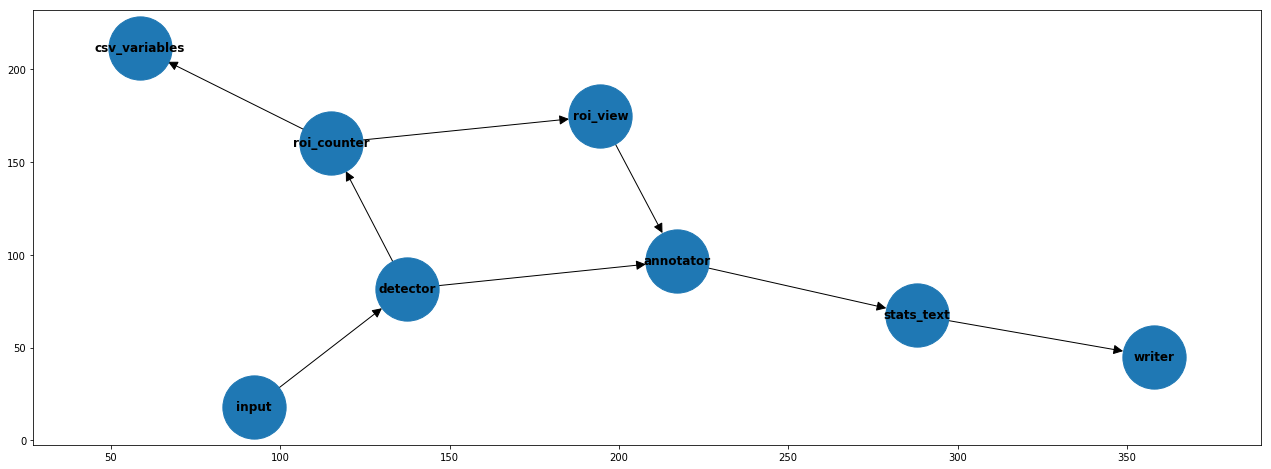

In [57]:
import matplotlib.pyplot as plt

fig,axes = plt.subplots(1,1,figsize=(22,8))
pipeline.plot(ax=axes)

In [58]:
# 5. Execute
pipeline.execute()
print("Total execution time [s]:", pipeline.get_total_execution_time())

  0%|          | 0/100.0 [00:00<?, ?it/s]

Total execution time [s]: 655.7459518609976


In [ ]:
import pandas as pd

# 6. Report (optional)
metrics_df = pd.DataFrame.from_dict(pipeline.get_metrics(), orient='index',columns=["time [s]"])
metrics_df

### Exploration of results

Display the output video with annotated bounding boxes.

Note: currently XVID format is not supported by jupyter.

In [59]:
%%HTML
<div style="text-align: center">
    <video width="600" height="400" controls>
      <source src="../data/output/test_output.avi" type="video/mp4">
    </video>
</div>

#### Time series

In [61]:
import pandas as pd
df = pd.read_csv(VARIABLES_FILENAME)

df.head(5)

,frame_num,q_upper_left,q_lower_left,q_upper_right,q_lower_right,q_winch,q_total
0,10000,0,0,1,0,3,4
1,10001,0,0,1,0,3,4
2,10002,0,0,1,0,3,4
3,10003,0,0,0,0,3,3
4,10004,0,0,0,0,3,3


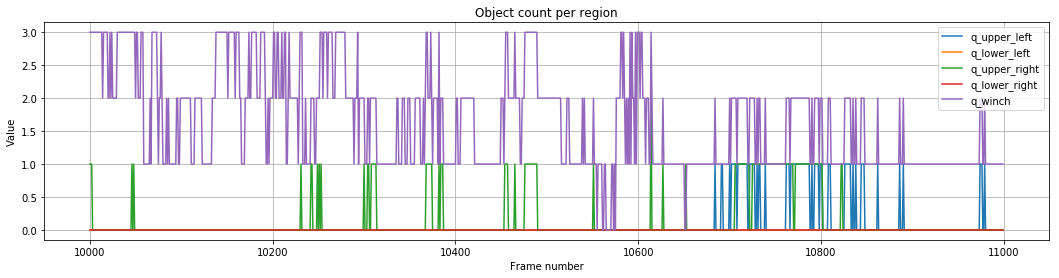

In [63]:
fig,axes = plt.subplots(1,1,figsize=(18,4))
axes.grid(True)

variables = [
    "q_upper_left",
    "q_lower_left",
    "q_upper_right",
    "q_lower_right",
    "q_winch"   
]
for v in variables:
    axes.plot(df.frame_num,df[v])
axes.legend(variables)
axes.set_xlabel("Frame number")
axes.set_ylabel("Value")
axes.set_title("Object count per region");

## A pipeline for triggering events from ROI activity

In [109]:
#FIXME
import json
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

from videoanalytics.pipeline.sinks.roi.events import ROIEvents, ROIEventsCSVWriter

### Pipeline instantiation and execution

In [67]:
DEEPSORT_MODEL_FILENAME = DATA_PATH+"object_tracking/mars-small128.pb"

In [107]:
ROI_EVENTS_FILENAME = DATA_PATH+"/output/roi_events.csv"

In [155]:
from videoanalytics.pipeline.sinks.object_tracking.deepsort import DeepSORT
from videoanalytics.pipeline.sinks.object_tracking import TrackedObjectsAnnotator, TrackedObjectsCSVWriter

# 1. Create the global context
context = {}

# 2. Create the pipeline
pipeline = Pipeline()

# 3. Add components

# 3.1 Source
pipeline.add_component( VideoReader( "input",context,
                 video_path=INPUT_VIDEO,
                 start_frame=START_FRAME,
                 max_frames=MAX_FRAMES))

# 3.2 Detector
pipeline.add_component( YOLOv4DetectorTF("detector",context,weights_filename=DETECTOR_WEIGHTS_FILENAME) )

# 3.3 ROI viewer
pipeline.add_component( ROIView("roi_view",context,filename=ROI_DEFINITION_FILE,alpha=0.6 ) )

# 3.4 Tracker (DeepSORT)
pipeline.add_component( DeepSORT("tracker",context,model_filename=DEEPSORT_MODEL_FILENAME) )
pipeline.add_component( TrackedObjectsAnnotator("tracker_annotator",context) )

# 3.5 Events generator
pipeline.add_component( ROIEvents("roi_events",context,filename=ROI_DEFINITION_FILE) )

# 3.6 Record events to CSV
pipeline.add_component( ROIEventsCSVWriter("roi_events_writer",context,ROI_EVENTS_FILENAME) )

# 3.7 Video Sink
pipeline.add_component(VideoWriter("writer",context,filename=OUTPUT_VIDEO))

# 4. Define connections
pipeline.set_connections([
    ("input", "detector"),
    ("detector", "tracker"),
    ("tracker", "roi_view"),    
    ("roi_view", "tracker_annotator"),
    ("tracker", "roi_events"),
    ("roi_events", "roi_events_writer"),
    ("tracker_annotator", "writer")
])

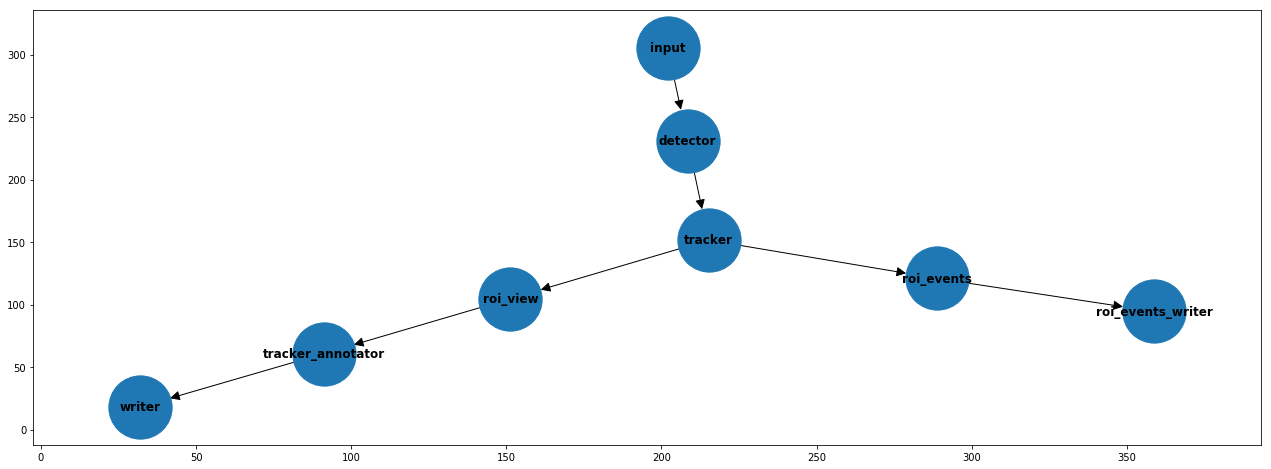

In [156]:
import matplotlib.pyplot as plt

fig,axes = plt.subplots(1,1,figsize=(22,8))
pipeline.plot(ax=axes)

In [125]:
# 5. Execute
pipeline.execute()
print("Total execution time [s]:", pipeline.get_total_execution_time())

  0%|          | 0/100.0 [00:00<?, ?it/s]

Total execution time [s]: 767.0963284800018


**¿Is this approach suitable for online processing?**

If the detector inference time could be optimized, this might be a suitable approach for an online application.

In [126]:
import pandas as pd

# 6. Report (optional)
metrics_df = pd.DataFrame.from_dict(pipeline.get_metrics(), orient='index',columns=["time [s]"])
metrics_df

,time [s]
input_avg_dt,0.008531
roi_view_avg_dt,0.005932
detector_avg_dt,0.703006
tracker_avg_dt,0.016689
roi_events_avg_dt,0.000503
roi_events_writer_avg_dt,0.000008
tracker_annotator_avg_dt,0.000296
writer_avg_dt,0.030035


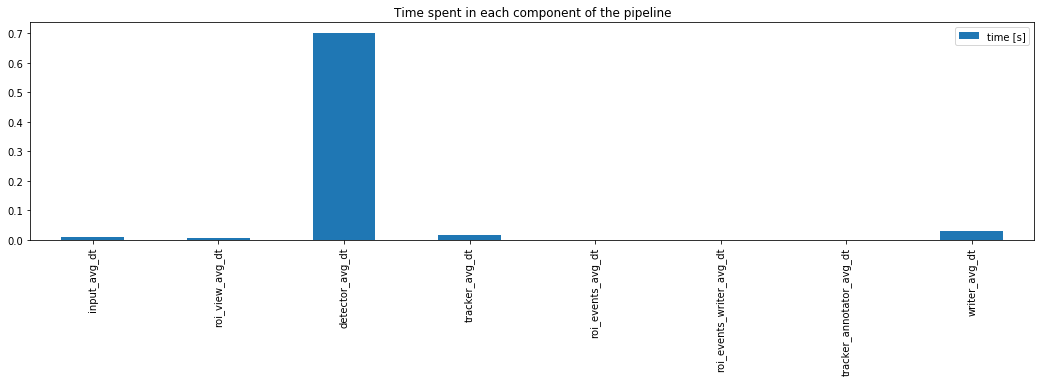

In [153]:
fig,axes = plt.subplots(1,1,figsize=(18,4))
metrics_df.plot.bar(ax=axes)
axes.set_title("Time spent in each component of the pipeline");

### Exploration of results

Display the output video with annotated ROIs.

Note: currently XVID format is not supported by jupyter.

In [135]:
%%HTML
<div style="text-align: center">
    <video width="600" height="400" controls>
      <source src="../data/output/test_output.avi" type="video/mp4">
    </video>
</div>

Events can be used as a starting point for counting objects, triggering alarms or to generate new variables with deeper insights.

In [136]:
import pandas as pd

df = pd.read_csv(ROI_EVENTS_FILENAME)
df.head(10)

,frame_num,event,obj_id,roi
0,2,ENTERED,1,SCREEN
1,2,ENTERED,2,SCREEN
2,2,ENTERED,3,SCREEN
3,2,ENTERED,2,winch
4,2,ENTERED,3,winch
5,233,ENTERED,1,lower_right
6,236,LEFT,1,lower_right
7,271,ENTERED,7,SCREEN
8,271,ENTERED,7,winch
9,358,ENTERED,1,lower_left


In [137]:
df.tail(10)

,frame_num,event,obj_id,roi
20,479,ENTERED,12,SCREEN
21,479,ENTERED,12,winch
22,648,ENTERED,13,SCREEN
23,648,ENTERED,13,upper_right
24,708,ENTERED,13,lower_right
25,719,ENTERED,16,SCREEN
26,719,ENTERED,16,upper_right
27,795,ENTERED,10,lower_right
28,796,LEFT,10,lower_right
29,827,ENTERED,17,SCREEN


In [150]:
df.groupby(["event","roi"]).count()

frame_num  obj_id
event   roi                           
ENTERED SCREEN              10      10
        lower_left           2       2
        lower_right          3       3
        upper_left           2       2
        upper_right          3       3
        winch                4       4
LEFT    lower_left           2       2
        lower_right          2       2
        upper_left           2       2